In [80]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pylab import subplot,imshow,title,gray,NullLocator
import scipy.misc as mi
import scipy.special as sp
from PIL import Image
from itertools import chain
from sklearn.metrics import confusion_matrix, accuracy_score

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor


In [2]:
# visualizza dati
def displayData(X, t, rows=10, cols=10, img_ind=None, size =16, class_value = False):
    X = X.numpy()
    t = t.numpy()
    if len(X)>rows*cols:
        img_ind = np.random.permutation(len(X))[0:rows * cols]
    else:
        img_ind = range(rows*cols)
    fig = plt.figure(figsize = (size,size))
    fig.patch.set_facecolor('white')
    ax = fig.gca()
    for i in range(100):
        plt.subplot(10,10,i+1)
        plt.imshow([255-x for x in X[img_ind[i]]], cmap='gray', interpolation='gaussian')
        if class_value:
            plt.title("{}".format(t[img_ind[i]]),fontsize = 20)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.axis('off') 
    plt.subplots_adjust(top=1)
    plt.show()

In [3]:
def plotData(X, Y, c, npixel=28):
    X = X.numpy()
    m, n = X.shape
    image = np.array(X[c,:])
    plt.figure(figsize = (6,6))
    plt.imshow((image.reshape(npixel, npixel)), cmap='Greys', interpolation='quadric')
    plt.show()

In [4]:
def plotAccuracy(acc_history_train, acc_history_test):
    plt.figure(figsize = (12,8))
    plt.plot(acc_history_train, marker='o', markersize=5, label='Train')
    plt.plot(acc_history_test, marker='o', markersize=5, label='Test')
    plt.legend()
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.show()

In [5]:
def save_model(m,filename):
    model_json = m.to_json()
    with open(filename+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    m.save_weights(filename+".h5")
    print("Saved model to disk")

In [6]:
def load_model(filename):
    json_file = open(filename+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    m = model_from_json(loaded_model_json)
    # load weights into new model
    m.load_weights(filename+".h5")
    print("Loaded model from disk")
    return m

Fissa il numero di classi. Leggi i dati.

In [7]:
nb_classes = 10

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

#(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [19]:
print(f'Training set features {train_data.data.numpy().shape}')
print(f'Training set targets {train_data.targets.numpy().shape[0]}')

Training set features (60000, 28, 28)
Training set targets 60000


In [21]:
print(f'Test set features {test_data.data.numpy().shape}')
print(f'Test set targets {test_data.targets.numpy().shape[0]}')

Test set features (10000, 28, 28)
Test set targets 10000


Esempio di dati

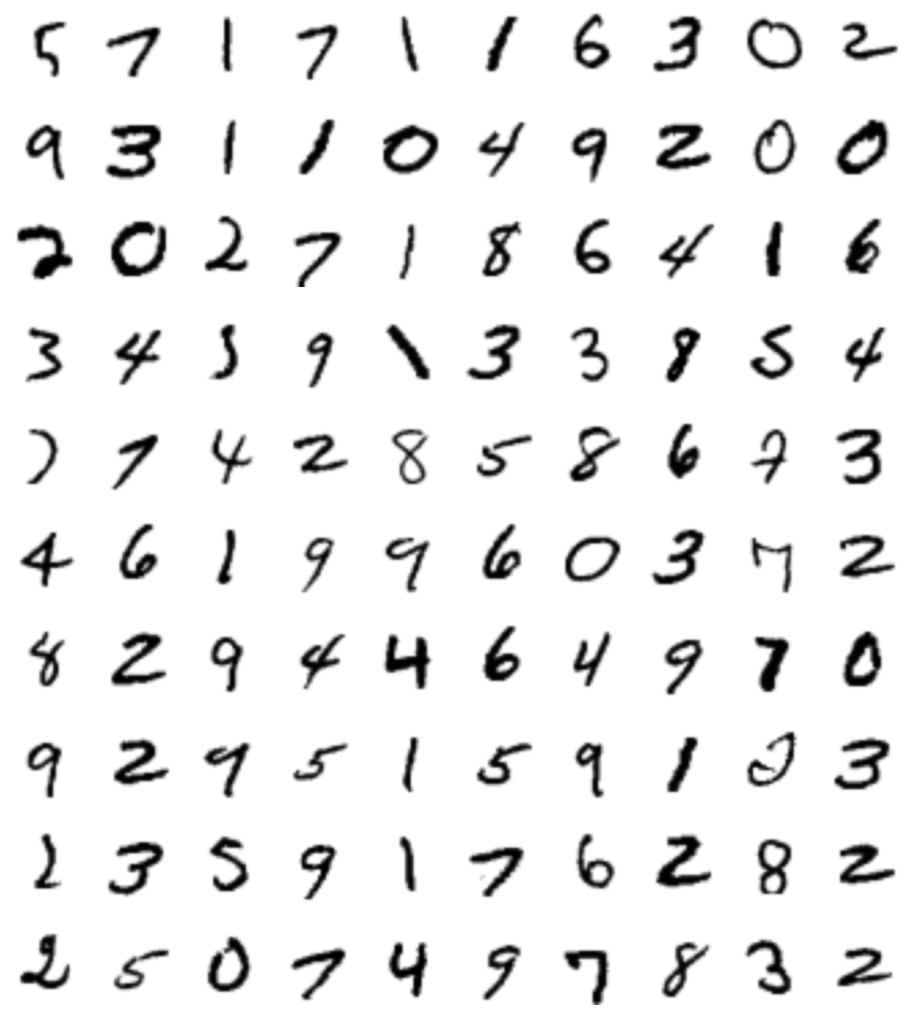

In [22]:
displayData(train_data.data[100:200], train_data.targets[100:200])

Esempio di dati con relativa classe

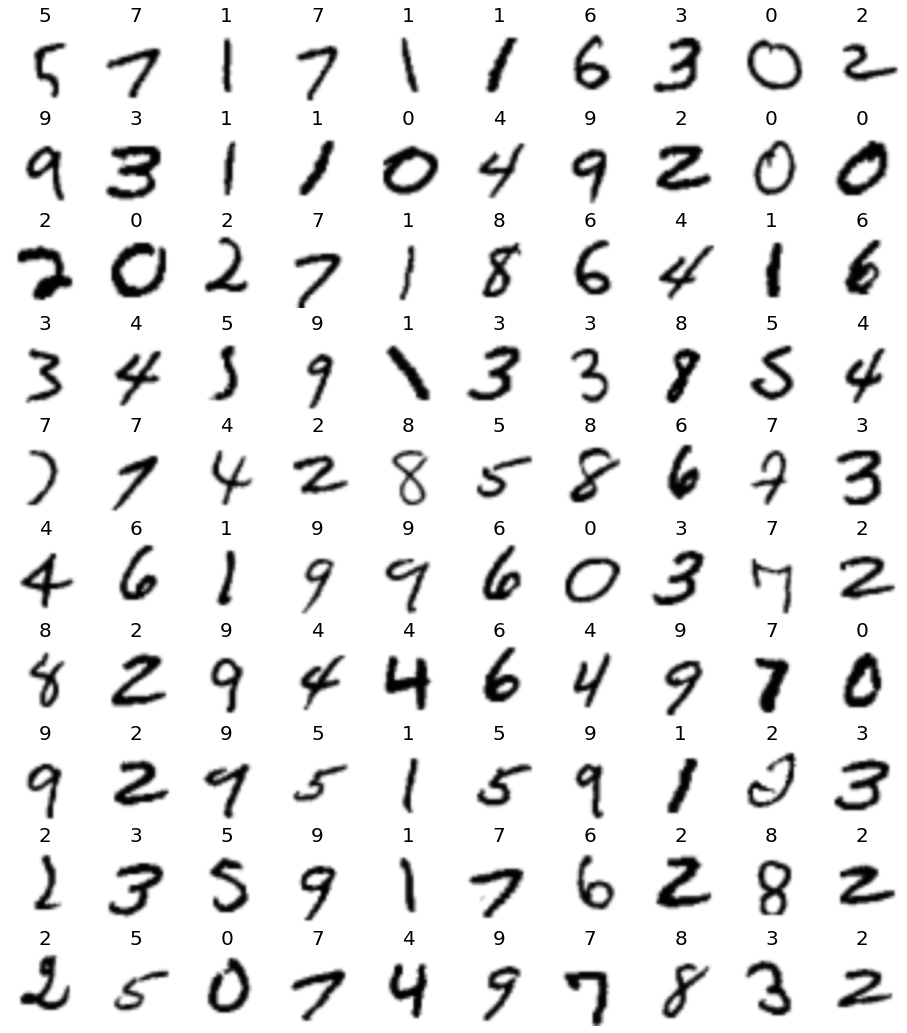

In [23]:
displayData(train_data.data[100:200], train_data.targets[100:200], class_value=True)

In [89]:
image_size = train_data.data.numpy().shape[1] * train_data.data.numpy().shape[2]
num_classes = 10
num_epochs = 3
batch_size = 100
learning_rate = 0.001

In [27]:

loaders = {
            'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=1),
    
            'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=1),
        }

In [28]:
class NeuralNet0(nn.Module):
    def __init__(self, input_size, num_classes):
         super(NeuralNet0, self).__init__()
         self.input_size = input_size
         self.l1 = nn.Linear(input_size, num_classes)   

    def forward(self, x):
         out = self.l1(x)
         # no activation and no softmax at the end
         return out 

In [30]:

class NeuralNet1(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet1, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

In [71]:
hidden_size = 500
model = NeuralNet1(image_size, hidden_size, num_classes)
model = NeuralNet0(image_size, num_classes)

In [72]:
print(model)

NeuralNet0(
  (l1): Linear(in_features=784, out_features=10, bias=True)
)


In [73]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter l1.weight, shape torch.Size([10, 784])
Parameter l1.bias, shape torch.Size([10])


In [74]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [75]:
n_batches = len(loaders['train'])
n_val_batches = len(loaders['test'])


In [86]:
def train(model, loss_func, optimizer, eval_every=100, print_flag=False):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    for epoch in range(num_epochs):
        avg_loss = 0
        model.train()
        for batch, (batch_images, batch_labels) in enumerate(loaders['train']):
            batch_images = batch_images.reshape(-1, 28*28)

            optimizer.zero_grad()
            batch_outputs = model(batch_images)
            batch_loss = loss_func(batch_outputs, batch_labels)
            batch_loss.backward()
            optimizer.step()

            if (batch+1) % eval_every == 0:
                model.eval()
                with torch.no_grad():
                    train_loss = 0
                    train_acc = 0
                    for train_batch_images, train_batch_labels in loaders['train']:
                        train_batch_images = train_batch_images.reshape(-1, 28*28)
                        train_batch_outputs = model.forward(train_batch_images)
                        train_loss += loss_func(train_batch_outputs,train_batch_labels).item()/n_batches
                        _, train_batch_predictions = torch.max(train_batch_outputs.data, 1)
                        train_batch_equality = (train_batch_labels.data == train_batch_predictions)
                        train_acc += train_batch_equality.type(torch.FloatTensor).mean()/n_batches
                    val_loss = 0
                    val_acc = 0
                    for val_batch_images, val_batch_labels in loaders['test']:
                        val_batch_images = val_batch_images.reshape(-1, 28*28)
                        val_batch_outputs = model.forward(val_batch_images)
                        val_loss += loss_func(val_batch_outputs,val_batch_labels).item()/n_val_batches
                        _, val_batch_predictions = torch.max(val_batch_outputs.data, 1)
                        val_batch_equality = (val_batch_labels.data == val_batch_predictions)
                        batch_val_acc += val_batch_equality.type(torch.FloatTensor).mean()/n_val_batches
                model.train()
                train_losses.append(train_loss.detach())
                val_losses.append(val_loss)
                train_accs.append(train_acc)
                val_accs.append(val_acc)
                if print_flag:
                    to_print = f"Epoch: {epoch+1}/{num_epochs}"#+str(epoch+1)+"/"+str(num_epochs)
                    to_print += f" step: {batch+1}/{n_batches}  --  "
                    to_print += f" Train Loss: {batch_loss:.3f}"#.format(batch_loss)
                    to_print += f" Validation Loss: {batch_val_loss:.3f}"#.format(batch_val_loss)
                    to_print += f" Train Accuracy: {batch_acc:.3f}"#.format(batch_acc)
                    to_print += f" Validation Accuracy: {batch_val_acc:.3f}"#.format(batch_val_acc)
                    print(to_print)
    return train_losses, val_losses, train_accs, val_accs            

In [87]:
train_losses, val_losses, train_accs, val_accs = train(model, loss_func, optimizer, eval_every=100, print_flag=True)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff6009824c0>
Traceback (most recent call last):
  File "/Users/giorgio/opt/anaconda3/envs/py38/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/Users/giorgio/opt/anaconda3/envs/py38/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/giorgio/opt/anaconda3/envs/py38/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Users/giorgio/opt/anaconda3/envs/py38/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/Users/giorgio/opt/anaconda3/envs/py38/lib/python3.8/multiprocessing/connection.py", line 930, in wait
    ready = selector.select(timeout)
  File "/Users/giorgio/opt/anaconda3/envs/py38/lib/python3.8/selectors.py", lin

UnboundLocalError: local variable 'batch_val_acc' referenced before assignment

In [81]:
acc_values0 = history0.history['acc']
val_acc_values0 = history0.history['val_acc']

In [57]:
train_losses.detach()

AttributeError: 'list' object has no attribute 'detach'

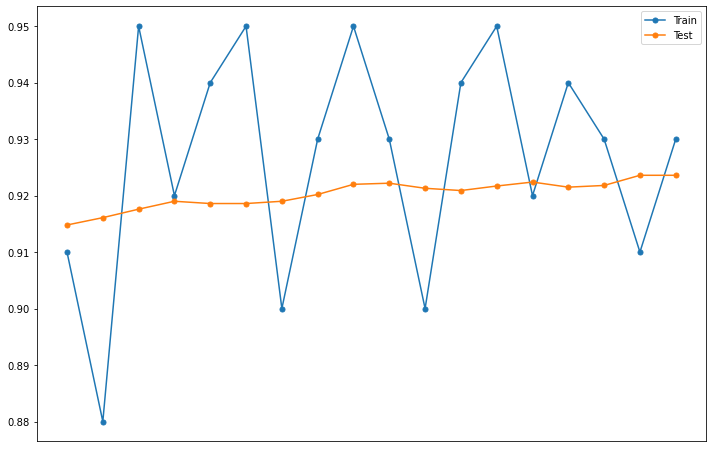

In [85]:
plotAccuracy(train_accs, val_accs)

In [84]:
predictions_train = model0.predict_classes(X_train, verbose=0)

In [85]:
confusion_matrix(y_train, predictions_train)

array([[5679,    0,   34,   23,   11,   39,   59,    5,   63,   10],
       [   0, 6543,   33,   22,    7,   44,    8,   12,   65,    8],
       [  46,   78, 5241,   98,  104,   19,   90,   92,  167,   23],
       [  23,   41,  148, 5414,    4,  205,   31,   61,  132,   72],
       [  15,   25,   36,    5, 5409,    3,   55,   18,   40,  236],
       [  73,   54,   38,  210,   67, 4581,   98,   21,  211,   68],
       [  44,   28,   47,    4,   47,   69, 5626,    6,   47,    0],
       [  28,   63,   75,   27,   64,    7,    3, 5757,   15,  226],
       [  40,  144,   69,  168,   31,  139,   51,   22, 5098,   89],
       [  36,   29,   24,   95,  186,   28,    6,  186,   45, 5314]])

In [86]:
accuracy_score(y_train, predictions_train)

0.9110333333333334

In [87]:
predictions_test = model0.predict_classes(X_test, verbose=0)

In [88]:
confusion_matrix(y_test, predictions_test)

array([[ 952,    0,    2,    4,    1,    4,   11,    1,    5,    0],
       [   0, 1107,    2,    4,    1,    1,    4,    0,   16,    0],
       [  10,   10,  904,   20,   10,    2,   14,   13,   42,    7],
       [   3,    2,   20,  914,    1,   27,    3,   12,   20,    8],
       [   1,    1,    3,    1,  921,    0,   13,    1,    8,   33],
       [   9,    5,    6,   34,   11,  759,   16,    8,   34,   10],
       [  13,    3,    5,    1,   11,   15,  906,    1,    3,    0],
       [   2,   14,   25,    6,    9,    0,    0,  929,    2,   41],
       [   8,    7,    7,   28,    9,   25,    9,   14,  856,   11],
       [  13,    6,    3,   13,   41,    7,    0,   24,    6,  896]])

In [89]:
accuracy_score(y_test, predictions_test)

0.9144

In [90]:
w = model0.layers[0].get_weights()[0]

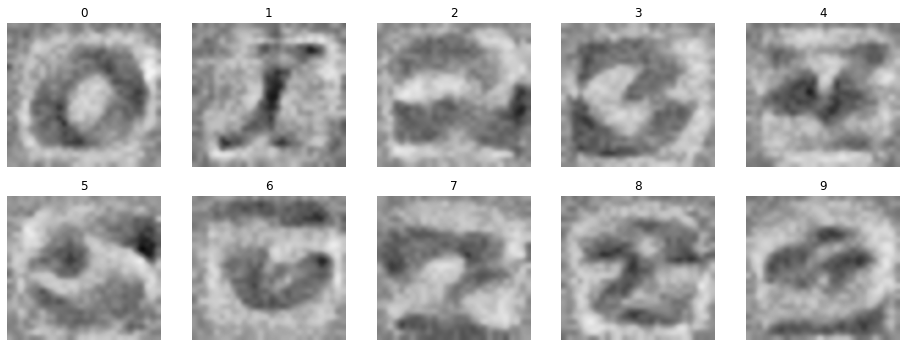

In [91]:
fig = plt.figure(figsize=(16,16))
fig.patch.set_facecolor('white')
for i in range(10):
    ax = subplot(2,5,i+1,frame_on=False, facecolor="#F8F8F8")
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())
    imshow(w[:,i].reshape(28,28), interpolation='quadric', 
           cmap=plt.get_cmap('Greys'), vmin=np.mean(w[:,i])-3.5*np.std(w[:,i]), 
           vmax=np.mean(w[:,i])+3.5*np.std(w[:,i]), aspect='auto')
    plt.title(i)
plt.subplots_adjust(top=0.4)
plt.show()

Elemento 3044


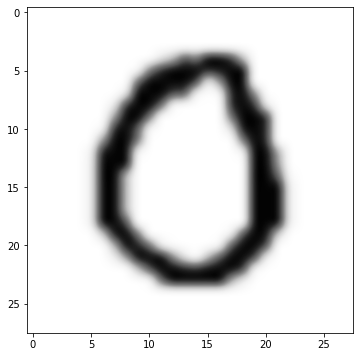

Un 0, classificato come 0


In [93]:
c = np.random.randint(0, X_test.shape[0])
p=model0.predict_classes(X_test[c:c+1,:], verbose=0)
print("Elemento "+str(c))
plotData(X_test, y_test, c)
print("Un "+str(y_test[c])+", classificato come " + str(p[0]))

In [109]:
# 3 layer NN
hidden_layer_width = 10
model1 = Sequential()
model1.add(Dense(hidden_layer_width, input_shape=(784,)))
model1.add(Activation('sigmoid'))
model1.add(Dropout(0.2))
model1.add(Dense(10))
model1.add(Activation('softmax'))
model1.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam')

In [111]:
history1 = model1.fit(X_train, Y_train, batch_size=512, epochs=50, verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 9us/step - loss: 0.5704 - acc: 0.8158 - val_loss: 0.3557 - val_acc: 0.9068
Epoch 2/50
60000/60000 [==============================] - 1s 10us/step - loss: 0.5672 - acc: 0.8153 - val_loss: 0.3531 - val_acc: 0.9080
Epoch 3/50
60000/60000 [==============================] - 1s 11us/step - loss: 0.5643 - acc: 0.8165 - val_loss: 0.3521 - val_acc: 0.9077
Epoch 4/50
60000/60000 [==============================] - 1s 10us/step - loss: 0.5592 - acc: 0.8200 - val_loss: 0.3459 - val_acc: 0.9105
Epoch 5/50
60000/60000 [==============================] - 1s 10us/step - loss: 0.5577 - acc: 0.8176 - val_loss: 0.3447 - val_acc: 0.9109
Epoch 6/50
60000/60000 [==============================] - 0s 7us/step - loss: 0.5529 - acc: 0.8197 - val_loss: 0.3423 - val_acc: 0.9106
Epoch 7/50
60000/60000 [==============================] - 1s 9us/step - loss: 0.5500 - acc: 0.8206 - val_loss: 0.3395 - val_acc: 0

In [96]:
acc_values1 = history1.history['acc']
val_acc_values1 = history1.history['val_acc']

epochs1 = range(1, len(acc_values1) + 1)

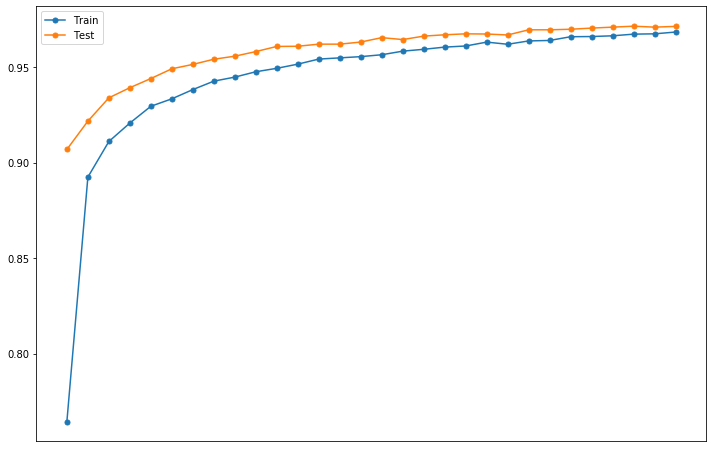

In [97]:
plotAccuracy(acc_values1, val_acc_values1)

In [98]:
predictions_train = model1.predict_classes(X_train, verbose=0)

In [99]:
confusion_matrix(y_train, predictions_train)

array([[5879,    0,    7,    2,    5,    2,    9,    1,   14,    4],
       [   1, 6675,   18,    5,    7,    2,    2,    9,   20,    3],
       [   7,    4, 5876,   16,   13,    3,    2,   18,   15,    4],
       [   4,    2,   35, 5971,    3,   42,    0,   26,   33,   15],
       [   4,    8,    7,    0, 5752,    2,   12,    5,    7,   45],
       [   9,    5,    4,   38,    7, 5309,   20,    0,   18,   11],
       [  14,    4,    1,    0,    9,    8, 5869,    0,   13,    0],
       [   2,   15,   36,    2,   24,    3,    0, 6154,    5,   24],
       [   8,   21,    8,   22,    8,   14,    5,    6, 5745,   14],
       [   9,    6,    1,   26,   63,   11,    2,   30,   22, 5779]])

In [100]:
accuracy_score(y_train, predictions_train)

0.9834833333333334

In [101]:
predictions_test = model1.predict_classes(X_test, verbose=0)

In [102]:
confusion_matrix(y_test, predictions_test)

array([[ 967,    0,    1,    0,    1,    1,    6,    2,    2,    0],
       [   0, 1121,    4,    0,    0,    1,    1,    2,    6,    0],
       [   5,    1, 1002,    4,    4,    1,    3,    5,    7,    0],
       [   0,    0,    5,  988,    0,    5,    0,    7,    5,    0],
       [   1,    0,    5,    0,  956,    0,    7,    0,    2,   11],
       [   2,    1,    0,   13,    2,  858,    8,    1,    4,    3],
       [   5,    3,    3,    1,    6,    4,  935,    0,    1,    0],
       [   2,    6,   13,    2,    3,    0,    0,  989,    3,   10],
       [   6,    2,    4,    5,    7,    4,    3,    7,  936,    0],
       [   3,    6,    0,    8,   15,    4,    3,    7,    2,  961]])

In [103]:
accuracy_score(y_test, predictions_test)

0.9713

In [37]:
w0 = model1.layers[0].get_weights()[0]
w1 = model1.layers[3].get_weights()[0]
w = np.dot(w0,w1)

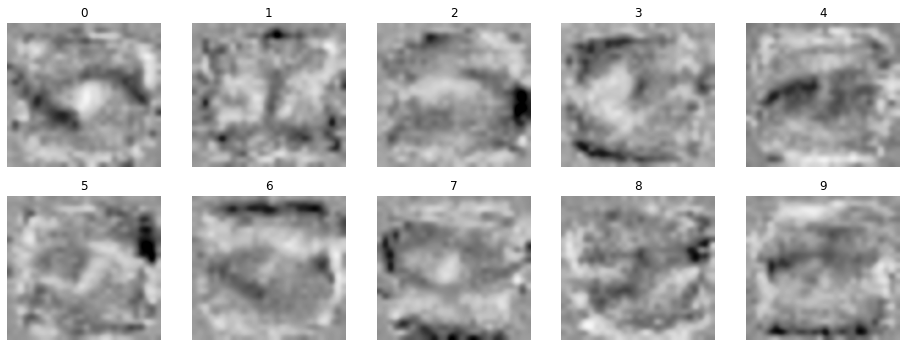

In [38]:
fig = plt.figure(figsize=(16,16))
fig.patch.set_facecolor('white')
for i in range(10):
    ax = subplot(2,5,i+1,frame_on=False, facecolor="#F8F8F8")
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())
    imshow(w[:,i].reshape(28,28), interpolation='quadric', 
           cmap=plt.get_cmap('Greys'), vmin=np.mean(w[:,i])-3.5*np.std(w[:,i]), 
           vmax=np.mean(w[:,i])+3.5*np.std(w[:,i]), aspect='auto')
    plt.title(i)
plt.subplots_adjust(top=0.4)
plt.show()

In [39]:
# 4 layer NN
hidden_layer1_width = 120
hidden_layer2_width = 50
model2 = Sequential()
model2.add(Dense(hidden_layer1_width, input_shape=(784,)))
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
model2.add(Dense(hidden_layer2_width))
model2.add(Activation('relu'))
model2.add(Dropout(0.2))
model2.add(Dense(10))
model2.add(Activation('softmax'))

In [40]:
model2.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam')

In [41]:
history2 = model2.fit(X_train, Y_train, batch_size=1024, epochs=10, verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 24us/step - loss: 1.0512 - acc: 0.6737 - val_loss: 0.3509 - val_acc: 0.9042
Epoch 2/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.4115 - acc: 0.8790 - val_loss: 0.2466 - val_acc: 0.9288
Epoch 3/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.3123 - acc: 0.9081 - val_loss: 0.2009 - val_acc: 0.9409
Epoch 4/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.2637 - acc: 0.9215 - val_loss: 0.1728 - val_acc: 0.9495
Epoch 5/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.2286 - acc: 0.9341 - val_loss: 0.1527 - val_acc: 0.9539
Epoch 6/10
60000/60000 [==============================] - 2s 25us/step - loss: 0.2013 - acc: 0.9411 - val_loss: 0.1346 - val_acc: 0.9600
Epoch 7/10
60000/60000 [==============================] - 1s 22us/step - loss: 0.1835 - acc: 0.9461 - val_loss: 0.1262 - val_acc

In [42]:
acc_values2 = history2.history['acc']
val_acc_values2 = history2.history['val_acc']

epochs2 = range(1, len(acc_values2) + 1)

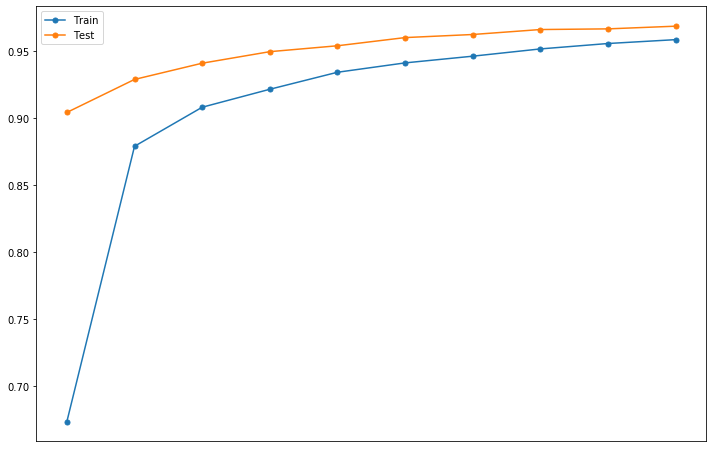

In [43]:
plotAccuracy(acc_values2, val_acc_values2)

In [44]:
predictions_train = model2.predict_classes(X_train, verbose=0)

In [45]:
confusion_matrix(y_train, predictions_train)

array([[5841,    1,    5,    6,    5,   10,   22,    4,   22,    7],
       [   1, 6652,   28,   14,   10,    2,    1,   11,   21,    2],
       [  12,    9, 5839,   20,   17,    4,    5,   31,   19,    2],
       [   5,    6,   45, 5932,    2,   44,    1,   30,   48,   18],
       [   4,   11,   17,    0, 5700,    2,   18,    8,    6,   76],
       [  19,    3,    7,   52,    6, 5260,   30,    6,   25,   13],
       [  18,    6,    6,    1,    9,   22, 5846,    0,   10,    0],
       [   8,   20,   38,    7,   18,    0,    1, 6127,    4,   42],
       [   6,   27,   12,   53,   13,   28,   15,    7, 5665,   25],
       [  16,   13,    0,   61,   59,   11,    2,   47,   28, 5712]])

In [46]:
accuracy_score(y_train, predictions_train)

0.9762333333333333

In [47]:
predictions_test = model2.predict_classes(X_test, verbose=0)

In [48]:
confusion_matrix(y_test, predictions_test)

array([[ 969,    0,    1,    2,    0,    3,    3,    1,    1,    0],
       [   0, 1122,    4,    0,    0,    0,    4,    1,    4,    0],
       [   5,    2,  999,    5,    4,    0,    2,    9,    6,    0],
       [   1,    0,    7,  981,    0,    6,    0,    9,    5,    1],
       [   1,    1,    7,    0,  956,    0,    3,    0,    2,   12],
       [   5,    1,    0,   11,    2,  854,   10,    1,    6,    2],
       [   7,    3,    1,    0,    7,    9,  926,    0,    5,    0],
       [   1,    9,   12,    4,    1,    0,    0,  994,    0,    7],
       [   4,    1,    2,   11,    6,    7,    3,    6,  931,    3],
       [   7,    6,    0,   12,   15,    3,    0,    6,    7,  953]])

In [49]:
accuracy_score(y_test, predictions_test)

0.9685

In [50]:
w0 = model2.layers[0].get_weights()[0]
w1 = model2.layers[3].get_weights()[0]
w2 = model2.layers[6].get_weights()[0]
w = np.dot(np.dot(w0,w1),w2)

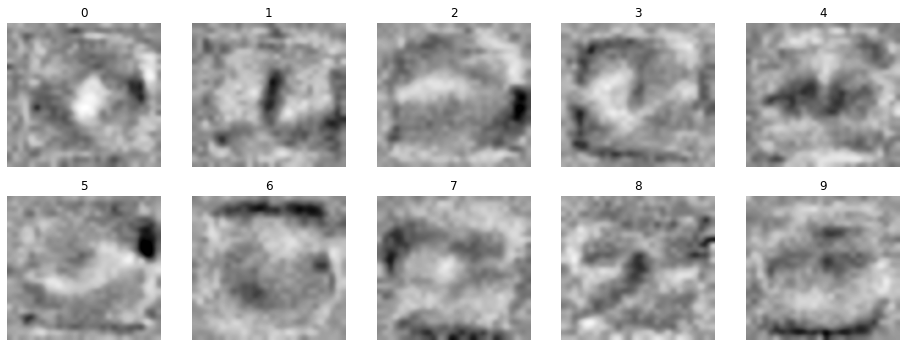

In [51]:
fig = plt.figure(figsize=(16,16))
fig.patch.set_facecolor('white')
for i in range(10):
    ax = subplot(2,5,i+1,frame_on=False, facecolor="#F8F8F8")
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())
    imshow(w[:,i].reshape(28,28), interpolation='quadric', 
           cmap=plt.get_cmap('Greys'), vmin=np.mean(w[:,i])-3.5*np.std(w[:,i]), 
           vmax=np.mean(w[:,i])+3.5*np.std(w[:,i]), aspect='auto')
    plt.title(i)
plt.subplots_adjust(top=0.4)
plt.show()

In [52]:
model3 = Sequential()
model3.add(Conv2D(30, (5, 5), input_shape=(1, 28, 28), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(15, (3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.2))
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dense(50, activation='relu'))
model3.add(Dense(10, activation='softmax'))

In [53]:
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [54]:
X_train_c = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test_c = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

In [55]:
history3 = model3.fit(X_train_c, Y_train, batch_size=1024, epochs=10, verbose=1, validation_data=(X_test_c, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 44s 736us/step - loss: 1.0300 - acc: 0.6588 - val_loss: 0.2687 - val_acc: 0.9244
Epoch 2/10
60000/60000 [==============================] - 43s 715us/step - loss: 0.2365 - acc: 0.9305 - val_loss: 0.1213 - val_acc: 0.9642
Epoch 3/10
60000/60000 [==============================] - 48s 798us/step - loss: 0.1437 - acc: 0.9572 - val_loss: 0.0790 - val_acc: 0.9761
Epoch 4/10
60000/60000 [==============================] - 44s 739us/step - loss: 0.1098 - acc: 0.9670 - val_loss: 0.0671 - val_acc: 0.9780
Epoch 5/10
60000/60000 [==============================] - 43s 717us/step - loss: 0.0916 - acc: 0.9718 - val_loss: 0.0538 - val_acc: 0.9840
Epoch 6/10
60000/60000 [==============================] - 45s 755us/step - loss: 0.0789 - acc: 0.9754 - val_loss: 0.0458 - val_acc: 0.9850
Epoch 7/10
60000/60000 [==============================] - 45s 755us/step - loss: 0.0701 - acc: 0.9786 - val_loss: 0.

In [56]:
acc_values3 = history3.history['acc']
val_acc_values3 = history3.history['val_acc']

epochs3 = range(1, len(acc_values3) + 1)

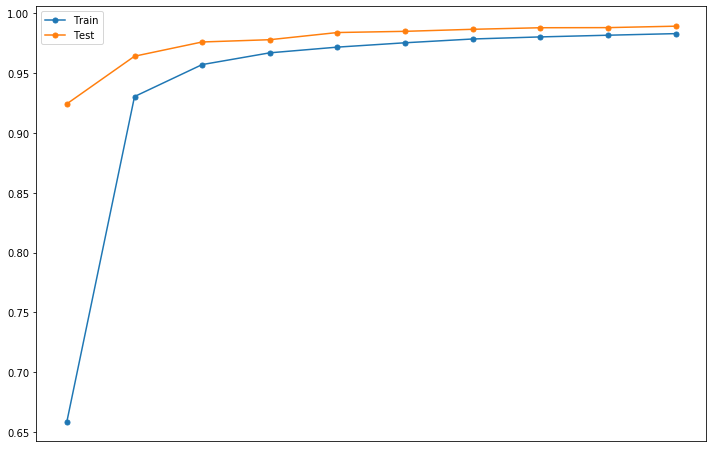

In [57]:
plotAccuracy(acc_values3, val_acc_values3)

In [58]:
predictions_train = model3.predict_classes(X_train_c, verbose=0)

In [59]:
confusion_matrix(y_train, predictions_train)

array([[5891,    1,    2,    0,    2,    5,   11,    1,    6,    4],
       [   1, 6697,    7,    1,    2,    0,    3,   17,   13,    1],
       [   4,    7, 5888,   11,    5,    0,    1,   12,   23,    7],
       [   1,    0,   15, 6030,    0,   35,    1,   19,   21,    9],
       [   2,    4,    4,    0, 5795,    1,    8,    8,    5,   15],
       [   1,    1,    1,   13,    1, 5370,   22,    1,    8,    3],
       [   5,    3,    2,    1,    5,    7, 5883,    0,   12,    0],
       [   1,    8,   11,    1,    2,    0,    0, 6233,    6,    3],
       [   6,    6,    5,    6,    4,   14,   12,    3, 5785,   10],
       [  10,    3,    0,   10,   29,   17,    1,   30,   21, 5828]])

In [60]:
accuracy_score(y_train, predictions_train)

0.99

In [66]:
predictions_test = model3.predict_classes(X_test, verbose=0)

ValueError: Error when checking input: expected conv2d_1_input to have 4 dimensions, but got array with shape (10000, 784)

In [64]:
confusion_matrix(y_test, predictions_test)

array([[ 969,    0,    1,    2,    0,    3,    3,    1,    1,    0],
       [   0, 1122,    4,    0,    0,    0,    4,    1,    4,    0],
       [   5,    2,  999,    5,    4,    0,    2,    9,    6,    0],
       [   1,    0,    7,  981,    0,    6,    0,    9,    5,    1],
       [   1,    1,    7,    0,  956,    0,    3,    0,    2,   12],
       [   5,    1,    0,   11,    2,  854,   10,    1,    6,    2],
       [   7,    3,    1,    0,    7,    9,  926,    0,    5,    0],
       [   1,    9,   12,    4,    1,    0,    0,  994,    0,    7],
       [   4,    1,    2,   11,    6,    7,    3,    6,  931,    3],
       [   7,    6,    0,   12,   15,    3,    0,    6,    7,  953]])

In [65]:
accuracy_score(y_test, predictions_test)

0.9685